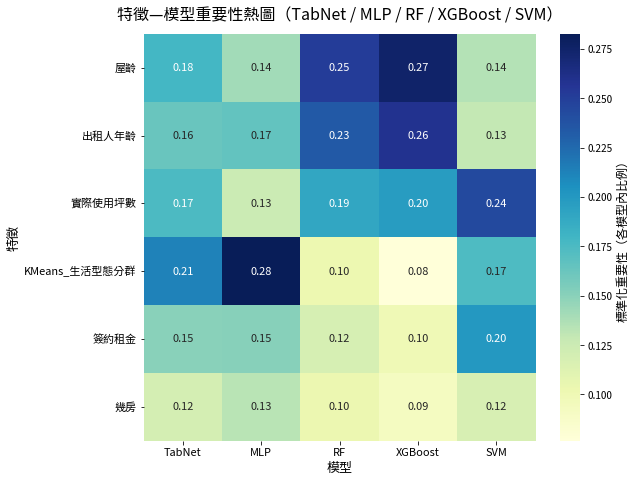

In [6]:
# -*- coding: utf-8 -*-
# ====== 匯入 ======
import os
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# ====== 下載並設定繁體中文字體 ======
font_url = 'https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/TraditionalChinese/SourceHanSansTC-Regular.otf'
font_path = 'SourceHanSansTC-Regular.otf'
if not os.path.exists(font_path):
    print("正在下載中文字體...")
    urllib.request.urlretrieve(font_url, font_path)
    print("字體下載完成！")

# 確保字體被 Matplotlib 註冊，並設定為預設字型
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()    # 例如 'Source Han Sans TC'
plt.rcParams['axes.unicode_minus'] = False            # 避免負號亂碼

# ====== 你的五個模型 SHAP 平均重要性（第一群變數） ======
# XGBoost
xgb = {
    '屋齡': 0.185707, '出租人年齡': 0.174907, '實際使用坪數': 0.133862,
    '簽約租金': 0.067173, '幾房': 0.062596, 'KMeans_生活型態分群': 0.051756
}
# RF
rf = {
    '屋齡': 0.054519, '出租人年齡': 0.050656, '實際使用坪數': 0.041209,
    '簽約租金': 0.025640, '幾房': 0.022351, 'KMeans_生活型態分群': 0.022286
}
# SVM
svm = {
    '實際使用坪數': 0.078065, '簽約租金': 0.064313, 'KMeans_生活型態分群': 0.056076,
    '屋齡': 0.043393, '出租人年齡': 0.041457, '幾房': 0.037646
}
# MLP
mlp = {
    'KMeans_生活型態分群': 0.073576, '出租人年齡': 0.043130, '簽約租金': 0.039408,
    '屋齡': 0.036804, '幾房': 0.034745, '實際使用坪數': 0.032698
}
# TabNet
tabnet = {
    'KMeans_生活型態分群': 0.067964, '屋齡': 0.056806, '實際使用坪數': 0.055746,
    '出租人年齡': 0.052043, '簽約租金': 0.047987, '幾房': 0.038117
}

# ====== 組成 DataFrame（列：特徵；欄：模型）======
features = ['屋齡', 'KMeans_生活型態分群', '實際使用坪數', '出租人年齡', '簽約租金', '幾房']
df = pd.DataFrame({
    'Feature': features,
    'TabNet':  [tabnet[f] for f in features],
    'MLP':     [mlp[f] for f in features],
    'RF':      [rf[f] for f in features],
    'XGBoost': [xgb[f] for f in features],
    'SVM':     [svm[f] for f in features],
}).set_index('Feature')

# ====== 標準化（兩種擇一）======
NORMALIZE_MODE = 'proportion'   # 'proportion'（各模型欄位加總=1）或 'minmax'（各欄 0–1）

if NORMALIZE_MODE == 'proportion':
    df_norm = df.apply(lambda col: col / col.sum(), axis=0)
    cbar_label = '標準化重要性（各模型內比例）'
elif NORMALIZE_MODE == 'minmax':
    df_norm = df.apply(lambda col: (col - col.min()) / (col.max() - col.min() + 1e-12), axis=0)
    cbar_label = '標準化重要性（各模型 0–1）'
else:
    raise ValueError("NORMALIZE_MODE 必須是 'proportion' 或 'minmax'")

# 依「跨模型平均標準化重要性」排序特徵，提升可讀性
row_order = df_norm.mean(axis=1).sort_values(ascending=False).index
df_plot = df_norm.loc[row_order]

# ====== 繪圖 ======
plt.figure(figsize=(9, 6.8))
ax = sns.heatmap(
    df_plot,
    annot=True, fmt=".2f", cmap='YlGnBu',
    cbar_kws={'label': cbar_label},
    annot_kws={"size": 11}
)

# 取得 colorbar 並套用中文字體（重點修正）
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel(cbar_label, fontproperties=font_prop, fontsize=12)
for ticklab in cbar.ax.get_yticklabels():
    ticklab.set_fontproperties(font_prop)
cbar.ax.tick_params(labelsize=10)

# 中文標題與座標
plt.title("特徵—模型重要性熱圖（TabNet / MLP / RF / XGBoost / SVM）", fontproperties=font_prop, fontsize=16, pad=14)
plt.xlabel("模型", fontproperties=font_prop, fontsize=13)
plt.ylabel("特徵", fontproperties=font_prop, fontsize=13)

# 套字型到刻度
ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop, fontsize=11, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop, fontsize=11, rotation=0)

plt.tight_layout()
plt.show()

# ====== 若需要輸出 CSV ======
df_norm.to_csv("全模型_標準化_SHAP_特徵重要性.csv", encoding="utf-8-sig")
